<a href="https://colab.research.google.com/github/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/blob/main/Data_Collection_From_Twitter_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
!pip install PySastrawi==1.2.0
!pip install snscrape==0.5.0.20230113
!pip install nltk==3.7
!pip install transformers==4.26.1
!pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [167]:
# Import some libraries

import pandas as pd
from datetime import timedelta, datetime
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

import snscrape.modules.twitter as sntwitter

import datetime as dt
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud


from googletrans.client import Translator
translator = Translator()

from transformers import pipeline
sentiment_classifier =pipeline("sentiment-analysis")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [168]:
# Created a list to append all tweet attributes(data)
attributes_container = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('ikn lang:id').get_items()):  
    if i>100:
        break
    attributes_container.append([tweet.date, tweet.user.username,tweet.rawContent, tweet.sourceLabel])
    
# Creating a dataframe from the tweets list above 
tweets = pd.DataFrame(attributes_container, columns=["tweetcreatedts", "username", "tweet", "source"])
tweets.to_csv("tweet_data.csv")

In [169]:
tweets = pd.read_csv('tweet_data.csv')
tweets.sample(5)

,Unnamed: 0,tweetcreatedts,username,tweet,source
26,26,2023-03-05 02:48:22+00:00,rezaparadianan1,Banyak dampak positif dari IKN #KotaDuniaUntukSemua #IKNSejahterakanIndonesia #IKNPemerataanEkonomi https://t.co/1K85NGwwfe,Botbird tweets
86,86,2023-03-05 02:02:56+00:00,bhp_semarang,"Bukan Cuma Cerita, Ini Penampakan Terbaru Rumah Pekerja IKN https://t.co/J7zlbzM7qy \n\n@Kemenkumham_RI @bhp_semarang #bhpsemarang #kumhampasti #KumhamSemakinPasti #kamipasti #kemenkumhamri #kemenkumham #kumhamsehat #kumhamproduktif #twitter #news #berita",Twitter Web App
2,2,2023-03-05 03:25:34+00:00,VanessaPadmana7,Mari bersama dukung IKN https://t.co/2hVH9Ea6cu,Twitter for Android
55,55,2023-03-05 02:24:53+00:00,catatankaqihati,"Kereeen!! Kementerian Perhubungan (Kemenhub) baru akan menggarap jalur kereta api di ibu kota negara baru (IKN) Nusantara setelah 2025 mendatang.\nKemenhub saat ini tengah menyusun studi dari trase atau rencana tapak jalur kereta api di Kalimantan, khususnya kawasan IKN. https://t.co/Tqkl1TLCLg",Twitter for iPhone
75,75,2023-03-05 02:07:36+00:00,bhp_semarang,Wakil Ketua DPR Sebut Pemindahan IKN Bukan Sekadar Pindah Tempat https://t.co/yREhihyxPv \n\n@Kemenkumham_RI @bhp_semarang #bhpsemarang #kumhampasti #KumhamSemakinPasti #kamipasti #kemenkumhamri #kemenkumham #kumhamsehat #kumhamproduktif #twitter #news #berita,Twitter Web App


In [170]:
# Some functions for preprocessing text
def cleaningText(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet) # remove mentions
    tweet = re.sub(r'#[A-Za-z0-9]+', '', tweet) # remove hashtag
    tweet = re.sub(r'RT[\s]', '', tweet) # remove RT
    tweet = re.sub(r"http\S+", '', tweet) # remove link
    tweet = re.sub(r'[0-9]+', '', tweet) # remove numbers
    tweet = tweet.replace('\n', ' ') # replace new line into space
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    tweet = tweet.strip(' ') # remove characters space from both left and right text
    return tweet

def casefoldingText(tweet): # Converting all the characters in a text into lower case
    tweet = tweet.lower() 
    return tweet

key_norm = pd.read_csv('https://raw.githubusercontent.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/main/Dataset/kamus-slang-ind.csv', encoding='ISO-8859-1')
def text_normalize(tweet):
    tweet = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0]
    if (key_norm['singkat'] == word).any()
    else word for word in tweet.split()
    ])
    return tweet

def tokenizingText(tweet): # Tokenizing or splitting a string, text into a list of tokens
    tweet = word_tokenize(tweet) 
    return tweet

def filteringText(tweet): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in tweet:
        if txt not in listStopwords:
            filtered.append(txt)
    tweet = filtered 
    return tweet

def stemmingText(tweet): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tweet = [stemmer.stem(word) for word in tweet]
    return tweet

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [171]:
# Preprocessing tweets data
tweets['text_clean'] = tweets['tweet'].apply(cleaningText)
tweets['text_clean'] = tweets['text_clean'].apply(casefoldingText)
tweets['text_clean'] = tweets['text_clean'].apply(text_normalize)
tweets.drop(['tweet'], axis = 1, inplace = True)

tweets['text_preprocessed'] = tweets['text_clean'].apply(tokenizingText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(filteringText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(stemmingText)
tweets['text_to_sentence'] = tweets['text_preprocessed'].apply(toSentence)
tweets.drop(['text_clean'], axis = 1, inplace = True)
tweets.drop_duplicates(subset = 'text_to_sentence', inplace = True)

In [172]:
tweets.sample(5)

,Unnamed: 0,tweetcreatedts,username,source,text_preprocessed,text_to_sentence
87,87,2023-03-05 02:02:02+00:00,bhp_semarang,Twitter Web App,"[bobocabin, ikn, resmi, luncur, akomodasi, inap, perintah, ri, semarang]",bobocabin ikn resmi luncur akomodasi inap perintah ri semarang
12,12,2023-03-05 03:01:07+00:00,titalkamkawan,Twitter for Android,"[untung, ikn, anak, cucu, bangsa, nenek, moyang, bangun, sarana]",untung ikn anak cucu bangsa nenek moyang bangun sarana
34,34,2023-03-05 02:42:55+00:00,Cencendewi,Twitter for Android,"[mantap, jalan, ikn, selesai, ]",mantap jalan ikn selesai
99,99,2023-03-05 02:00:20+00:00,ChikaFirli,SocialPilot.co,"[ikn, nusantara, magnet, tumbuh, ekonomi, pintar, city]",ikn nusantara magnet tumbuh ekonomi pintar city
17,17,2023-03-05 02:59:57+00:00,BurnsIra1,Twitter Web App,"[masuk, januari, bangun, ikn, capai, persen]",masuk januari bangun ikn capai persen


In [173]:
tweets['text_en'] = tweets['text_to_sentence'].str.encode('ascii', 'ignore').apply(translator.translate, dest='en')
tweets['text_en'] = tweets['text_en'].apply(getattr, args=('text',))

In [174]:
tweets = (
    tweets
    .assign(sentiment = lambda x: x['text_en'].apply(lambda s: sentiment_classifier(s)))
    .assign(
        polarity = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
        score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score'])),
    )
)

In [175]:
tweets.sample(5)

,Unnamed: 0,tweetcreatedts,username,source,text_preprocessed,text_to_sentence,text_en,sentiment,polarity,score
6,6,2023-03-05 03:11:49+00:00,AnissaBilla7,Twitter Web App,"[usaha, mikro, tengah, muara, beloan, balikpapan, sambut, bangun, ikn]",usaha mikro tengah muara beloan balikpapan sambut bangun ikn,b'micro business in the middle of the estuary of Beloan Balikpapan welcomes the wake of IKN',"[{'label': 'POSITIVE', 'score': 0.9986574649810791}]",POSITIVE,0.998657
81,81,2023-03-05 02:05:57+00:00,jhonmie90,Twitter Web App,"[satu, insinyur, indonesia, dukung, penuh, bangun, ikn, dorong, perccepatan, digitalisasi]",satu insinyur indonesia dukung penuh bangun ikn dorong perccepatan digitalisasi,b'one Indonesian engineer fully supports building fish to accelerate digitization',"[{'label': 'POSITIVE', 'score': 0.9980366826057434}]",POSITIVE,0.998037
88,88,2023-03-05 02:00:22+00:00,ChikaFirli,SocialPilot.co,"[ikn, nusantara, pusat, ekonomi]",ikn nusantara pusat ekonomi,b'ikn archipelago economic center',"[{'label': 'POSITIVE', 'score': 0.9930012226104736}]",POSITIVE,0.993001
39,39,2023-03-05 02:38:40+00:00,Hinatapemalu,Twitter for Android,"[ikn, naik, ekonomi, kalimantan]",ikn naik ekonomi kalimantan,b'ikn to increase Kalimantan's economy,"[{'label': 'POSITIVE', 'score': 0.9974791407585144}]",POSITIVE,0.997479
53,53,2023-03-05 02:27:26+00:00,felisa_r14,Twitter for Android,"[pemuda, kalimantan, timur, dukung, bangun, ikn, nusantara]",pemuda kalimantan timur dukung bangun ikn nusantara,b'youth of east kalimantan support to build ikn archipelago',"[{'label': 'POSITIVE', 'score': 0.9827394485473633}]",POSITIVE,0.982739


In [176]:
print(tweets['polarity'].value_counts())

POSITIVE    65
NEGATIVE    31
Name: polarity, dtype: int64


In [177]:
# Export to csv file
tweets.to_excel(r'tweets_data_clean_with_polarity.xlsx', index = False, header = True, index_label=None)
tweets.head(10)

,Unnamed: 0,tweetcreatedts,username,source,text_preprocessed,text_to_sentence,text_en,sentiment,polarity,score
0,0,2023-03-05 03:31:03+00:00,critapewayangan,Twitter for Android,"[pegawai, negeri, sipil, butuh, naik, gaji, ajak, pindah, hutan, khayal, seolaholah, kantor, fasilitas, mewah, ikn, nya, gaib, kampung, bunian, kasat, mata, ntahla, waras, mau]",pegawai negeri sipil butuh naik gaji ajak pindah hutan khayal seolaholah kantor fasilitas mewah ikn nya gaib kampung bunian kasat mata ntahla waras mau,"b'civil servants need a raise, ask them to move to an imaginary forest, as if the office has luxurious facilities, the village of Bunian is visible, but you don't want to be sane'","[{'label': 'NEGATIVE', 'score': 0.9991552829742432}]",NEGATIVE,0.999155
1,1,2023-03-05 03:30:26+00:00,DwiraElza,Twitter Web App,"[kaca, jakarta, ikn, hambalang, jilid, welcome, indonesia, dyandra, joker, pertamina, hange]",kaca jakarta ikn hambalang jilid welcome indonesia dyandra joker pertamina hange,b'kaca Jakarta Ikn Hambalang Volume Welcome Indonesia Dyandra Joker Pertamina Hange',"[{'label': 'POSITIVE', 'score': 0.9403234720230103}]",POSITIVE,0.940323
2,2,2023-03-05 03:25:34+00:00,VanessaPadmana7,Twitter for Android,"[mari, dukung, ikn]",mari dukung ikn,b'let's support ikn',"[{'label': 'POSITIVE', 'score': 0.7104490995407104}]",POSITIVE,0.710449
3,3,2023-03-05 03:23:16+00:00,Satya7ogja3_,Twitter for Android,"[presiden, jokowi, target, bangun, pusat, latih, sepak, bola, ikn]",presiden jokowi target bangun pusat latih sepak bola ikn,president jokowi targets to build a football training center ikn',"[{'label': 'NEGATIVE', 'score': 0.9908431768417358}]",NEGATIVE,0.990843
4,4,2023-03-05 03:16:48+00:00,iamIKN,Twitter for Android,"[masha, allah, ]",masha allah,With God's cloth,"[{'label': 'NEGATIVE', 'score': 0.9224138855934143}]",NEGATIVE,0.922414
5,5,2023-03-05 03:13:01+00:00,Sinta_dew3,Twitter Web App,"[perintah, wadah, serap, tengaha, kerja, lokal, bangun, ikn]",perintah wadah serap tengaha kerja lokal bangun ikn,b'command ingest container in the middle of local work build icon',"[{'label': 'NEGATIVE', 'score': 0.9797905683517456}]",NEGATIVE,0.979791
6,6,2023-03-05 03:11:49+00:00,AnissaBilla7,Twitter Web App,"[usaha, mikro, tengah, muara, beloan, balikpapan, sambut, bangun, ikn]",usaha mikro tengah muara beloan balikpapan sambut bangun ikn,b'micro business in the middle of the estuary of Beloan Balikpapan welcomes the wake of IKN',"[{'label': 'POSITIVE', 'score': 0.9986574649810791}]",POSITIVE,0.998657
7,7,2023-03-05 03:11:46+00:00,bella1na,twittbot.net,"[masyarakat, indonesia, bangga, bangun, ikn, nusantara]",masyarakat indonesia bangga bangun ikn nusantara,b'Indonesian people are proud to build an archipelago',"[{'label': 'POSITIVE', 'score': 0.9998186230659485}]",POSITIVE,0.999819
8,8,2023-03-05 03:11:43+00:00,agnesia1meli,twittbot.net,"[ikn, nusantara, dorong, ekonomi]",ikn nusantara dorong ekonomi,b'ikn archipelago boosts economy',"[{'label': 'POSITIVE', 'score': 0.9995723366737366}]",POSITIVE,0.999572
9,9,2023-03-05 03:08:15+00:00,sindiaulianii,Botbird tweets,"[ikn, tingkat, ekonomi]",ikn tingkat ekonomi,b'ikn economic level',"[{'label': 'POSITIVE', 'score': 0.944138765335083}]",POSITIVE,0.944139


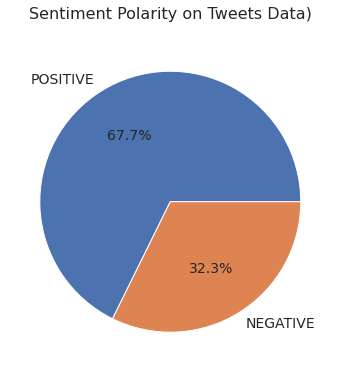

In [178]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in tweets['polarity'].value_counts()]
labels = list(tweets['polarity'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data)', fontsize = 16, pad = 20)
plt.show()

In [179]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = tweets[tweets['polarity'] == 'POSITIVE']
positive_tweets = positive_tweets[['text_to_sentence', 'score', 'polarity']].sort_values(by = 'score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,text_to_sentence,score,polarity
1,ikn nusantara bawa dampak positif,0.999871,POSITIVE
2,dampak positif ikn,0.999860,POSITIVE
3,untung ikn anak cucu bangsa nenek moyang bangun sarana,0.999859,POSITIVE
4,laku usaha mikro tengah bangga hadir ikn nusantara,0.999851,POSITIVE
5,bangun ikn dampak positif,0.999849,POSITIVE
6,patut bangga ikn nusantara bawa dampak positif indonesia,0.999820,POSITIVE
7,masyarakat indonesia bangga bangun ikn nusantara,0.999819,POSITIVE
8,sukses pindah ikn maju,0.999806,POSITIVE
9,ikn nusantara dongkrak ekonomi kalimantan,0.999690,POSITIVE
10,ikn nusantara magnet tumbuh ekonomi pintar city,0.999662,POSITIVE


In [180]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = tweets[tweets['polarity'] == 'NEGATIVE']
positive_tweets = positive_tweets[['text_to_sentence', 'score', 'polarity']].sort_values(by = 'score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,text_to_sentence,score,polarity
1,bodoh bayar pajak ikn subsidi bahan bakar minyak,0.999646,NEGATIVE
2,pegawai negeri sipil butuh naik gaji ajak pindah hutan khayal seolaholah kantor fasilitas mewah ikn nya gaib kampung bunian kasat mata ntahla waras mau,0.999155,NEGATIVE
3,ikn nusantara mati investor,0.998661,NEGATIVE
4,bukti ikn ancam mandek ab pimpin vitri welcome indonesia hange dyandra pertamina gen tanah merah anies bobby morningg murder renjun injakarta,0.998327,NEGATIVE
5,negara uni eropa tarik investasi ikn,0.997800,NEGATIVE
6,saewad ikn manfaat kembang proyek jabat perintah bayang proyek ikn batal cuan pulau reklamasi batal anis moga allah selamat negeri,0.996979,NEGATIVE
7,nusantara tarik gugus wilayah indonesia malay brunei amp negara asean korelasi nusantara ikn cakup wilayah asprov ambigu kan,0.993465,NEGATIVE
8,babat hutan cuan tanah gali batubara cuan keluar duit wajib rehabilitasi lingkung cuan proyek ikn enak benar,0.992855,NEGATIVE
9,samosir kemarin ngevlong lari lari ikn lari pantura,0.991963,NEGATIVE
10,presiden jokowi target bangun pusat latih sepak bola ikn,0.990843,NEGATIVE


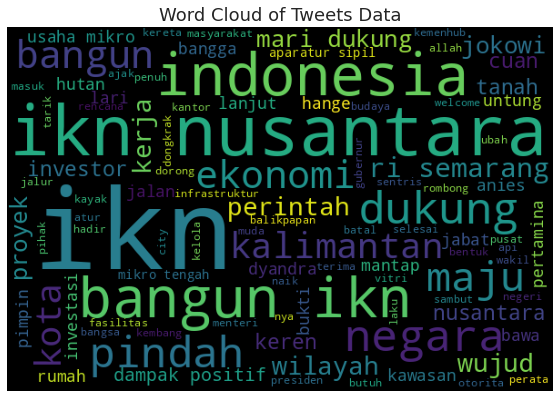

In [181]:
# Visualize word cloud
list_words=''
for tweet in tweets['text_preprocessed']:
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()